# Testing Various Model Types - Proving Efficacy of BERT Embeddings on Subcellular Location Prediction

### This notebook uses a BERT embedded FASTA file to predict subcellular location using various model types

In [1]:
from Bio import SeqIO
import pandas as pd
import torch
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import torch
from tape import ProteinBertModel, TAPETokenizer

import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb

import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


Using TensorFlow backend.
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/thomaswaldschmid

Automatically created module for IPython interactive environment


### Data Loading

In [2]:
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')

lookup_d = {}
seq_list = []
loc_list = []
count = 0
# generate lookup dictionary for labels from original fasta file 
for record in SeqIO.parse("data/deeploc_data_1024.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    count += 1
    desc_split = description.split(" ")
    loc_list.append(desc_split)
    #loc_list.append(desc_split[:len(desc_split)-2])
    if len(desc_split) == 3:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Nucleus"
        lookup_d[ID] = label
    
    else:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Nucleus"
        lookup_d[ID] = label

# Load Pre-Embedded Datasets For Analysis 

In [3]:
# load data from npz files
train_arrays = np.load('data/output_deeploc_train.npz', allow_pickle=True)
valid_arrays = np.load('data/output_deeploc_valid.npz', allow_pickle=True)
test_arrays = np.load('data/output_deeploc_test.npz', allow_pickle=True)

# Create Label Data Sets

In [4]:
id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}

# generate dataframes and associated labels from lookup 
def gen_df(df, label_list, arrays):
    l = list(arrays.keys())
    labels = []
    for a in l:
        d = arrays[a].item()['avg']
        append_df = pd.DataFrame(d)
        labels.append(lookup_d[a])
        df = df.append(append_df.transpose(), ignore_index=True)
    return df, labels

train_df, train_labels = gen_df(pd.DataFrame(), [], train_arrays)
valid_df, valid_labels = gen_df(pd.DataFrame(), [], valid_arrays)
test_df, test_labels = gen_df(pd.DataFrame(), [], test_arrays)

In [5]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels
train_y = [id_dict[label] for label in train_valid_labels]
test_y = [id_dict[label] for label in test_labels]


# XGBoost - Classifier 

In [6]:
d_train=xgb.DMatrix(train_valid_df, label=train_y)
d_test = xgb.DMatrix(test_df,label=test_y)

In [7]:
param = {
    'eta': 0.25, 
    'max_depth': 10,  
    'objective': 'multi:softprob',  
    'num_class': 10,
    'eval_metric': 'auc'} 

steps = 50  # The number of training iterations

In [8]:
model = xgb.train(param, d_train, steps)

In [9]:

preds = model.predict(d_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(test_y, best_preds, average='macro')))
print("Recall = {}".format(recall_score(test_y, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(test_y, best_preds)))

Precision = 0.5461920457389592
Recall = 0.46003058524426227
Accuracy = 0.6388436482084691


# Logistic Regression - ROC Curves - One vs. Rest Classifier

In [10]:
#Combine Valid And Train data sets 
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels

In [11]:
# Append labels to data frame
train_y = [id_dict[label] for label in train_valid_labels]
test_y = [id_dict[label] for label in test_labels]
#test_lab = [id_dict[label] for label in test_labels]

In [12]:
# Binarize the output for One Vs. Rest Classifiers
y_train = label_binarize(train_y, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_test = label_binarize(test_y, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y_test.shape[1]

In [13]:
# Run the On Vs. Rest Classifier
clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg',random_state=42,multi_class='multinomial'))
y_score = clf.fit(train_valid_df, y_train).decision_function(test_df)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



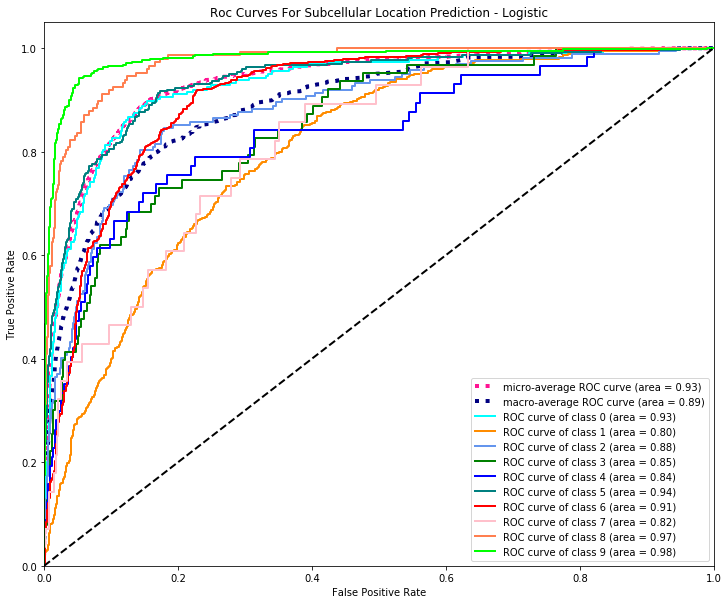

In [14]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw=2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','blue','teal','red','pink','coral','lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves For Subcellular Location Prediction - Logistic')
plt.legend(loc="lower right")
plt.show()

# One vs. Rest Classifier using SVC

In [15]:
# Run SVC Classifer Using Best Parameters for Grid Search CV
clf = OneVsRestClassifier(SVC(kernel='poly',C=500, max_iter=100000))
y_score = clf.fit(train_valid_df, y_train).decision_function(test_df)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thomaswaldschmi

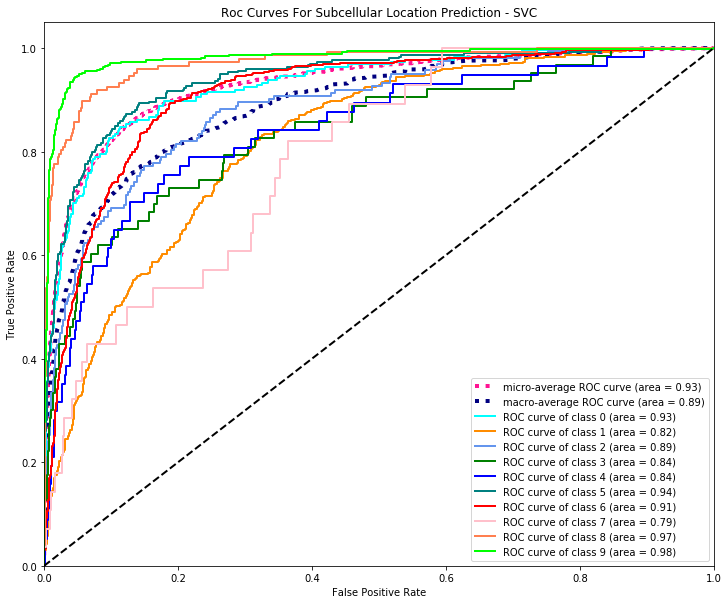

In [16]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','blue','teal','red','pink','coral','lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves For Subcellular Location Prediction - SVC')
plt.legend(loc="lower right")
plt.show()

# Keras DNN

In [17]:
train_lab = [id_dict[label] for label in train_labels]
valid_lab = [id_dict[label] for label in valid_labels]
test_lab = [id_dict[label] for label in test_labels]

In [18]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='softmax'))
model.add(Dense(32, activation='softmax'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
history = model.fit(train_df, to_categorical(train_lab), 
          validation_data=(valid_df, to_categorical(valid_lab)),
          epochs=200, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Train on 9220 samples, validate on 1002 samples
Epoch 1/200
9220/9220 [==============================] - 1s 116us/step - loss: 2.2166 - acc: 0.2450 - val_loss: 2.1440 - val_acc: 0.2974
Epoch 2/200
9220/9220 [==============================] - 1s 59us/step - loss: 2.0966 - acc: 0.2866 - val_loss: 2.0449 - val_acc: 0.2974
Epoch 3/200
9220/9220 [==============================] - 1s 67us/step - loss: 2.0072 - acc: 0.2866 - val_loss: 1.9586 - val_acc: 0.2974
Epoch 4/200
9220/9220 [==============================] - 1s 66us/step - loss: 1.9188 - acc: 0.3427 - val_loss: 1.8663 - val_acc: 0.4042
Epoch 5/200
9220/9220 [==============================] - 1s 63us/step - loss: 1.8221 - acc: 0.4230 - val_loss: 1.7685 - val_acc: 0.4112
Epoch 6/200
9220/9220 [==============================] - 1s 61us/step - loss: 1.7213 - acc: 0.4462 - val_loss: 1.6706 - val_acc: 0.4890
Epoch 7/200
9220/9220 [==============================] - 1s 60us/step - loss: 1.6263 - 

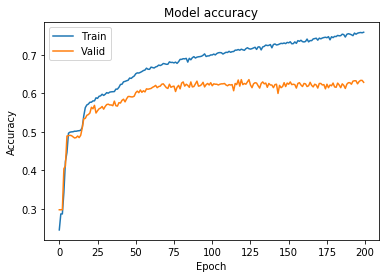

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [21]:
model.evaluate(test_df, to_categorical(test_lab))

2456/2456 [==============================] - 0s 41us/step


[1.3246537714905382, 0.6017915309446255]